## Background

In this notebook, I'll work through the first "Further Research" prompt from Chapter 13 (Convolutional Neural Networks) in the fastai book.

> What features other than edge detectors have been used in computer vision (especially before deep learning became popular)?

To start this exploration, I [prompted ChatGPT](https://chatgpt.com/share/db9feca7-3047-4392-8943-dd4376110266) and got a list of feature detection algorithms. I'll explore 7 of the algorithms that I could get to work and/or ran relatively quickly and/or ran without crashing my Google Colab kernel.

In [20]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

from math import sqrt

from skimage import data, exposure
from skimage.feature import blob_dog, blob_log, blob_doh, hog, local_binary_pattern
from skimage.color import rgb2gray, label2rgb
from skimage.transform import rotate

from sklearn import cluster, decomposition

## Corner Detectors

### Harris Corner Detection

The Harris Corner Detection algorithm was developed in 1988 by Chris Harris & Mike Stephens in their paper "A Combined Corner and Edge Detector". I'll use the example code given in the [OpenCV](https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html) documentation on this algorithm. I found the following image to help understand the concept of this algorithm:

![](1.png)

I created an image with simple shapes in Google Slides with varying rounded-ness of corners. I'll wrap the OpenCV documentation code in a function so I can call it with different parameters to experiment.

In [5]:
def do_corner_harris(fname='/content/shapes1.png', blockSize=2, ksize=3, k=0.04):
  img = cv.imread(fname)
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

  gray = np.float32(gray)
  dst = cv.cornerHarris(gray,blockSize,ksize,k)

  #result is dilated for marking the corners, not important
  dst = cv.dilate(dst,None)

  # Threshold for an optimal value, it may vary depending on the image.
  img[dst>0.01*dst.max()]=[0,0,255]

  cv2_imshow(img)

Using the default settings, the perfect square's corners are detected. I asked the new Claude 3.5-Sonnet model how `k` affects the algorithm and it said that:

>The value of k influences the trade-off between detecting true corners and rejecting edge-like features:
>  
> If k is too small: The algorithm becomes more sensitive to edges.
>  
> If k is too large: The algorithm may miss some corners.

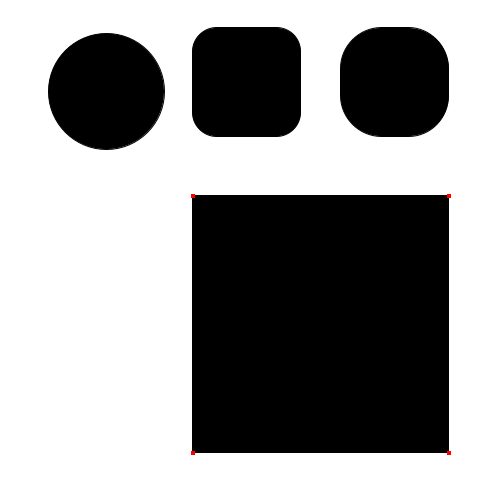

In [16]:
do_corner_harris()

If I reduce the value of `k` to `0.005`, it starts detecting corners in the rounded squares (which is fine) but also on the circle (which seems like noise).

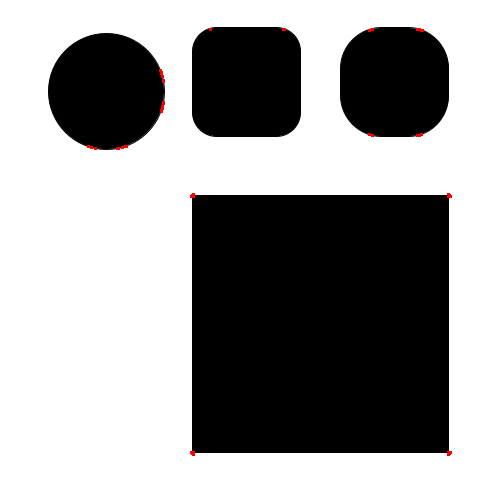

In [17]:
do_corner_harris(k=0.005)

I'll go back to `k=0.04` and change `blockSize` to see how it changes corner detection:



A larger `blockSize` (`20` instead of `2`) starts to detect the rounded corners of the rounded square.

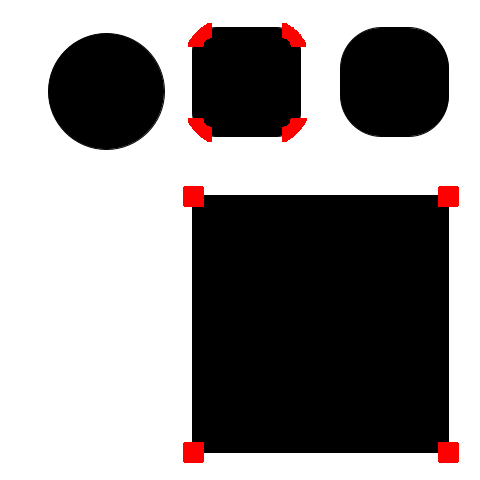

In [23]:
do_corner_harris(blockSize=20)

Decreasing `ksize` (`1` instead of the default `3`) seems to increase the sensitivity of the corner detection, as the rounded squares' corners are detected as well as points on the circle.

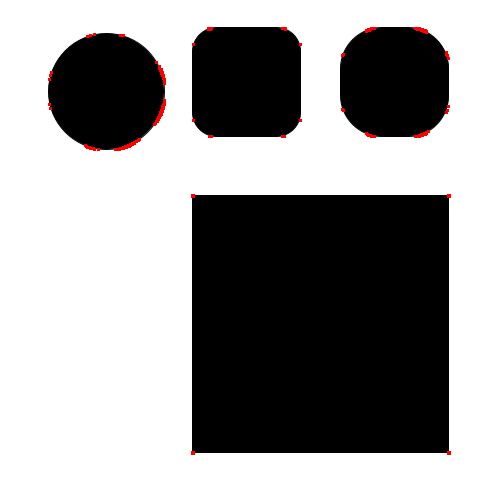

In [34]:
do_corner_harris(ksize=1)

### Shi-Tomasi Corner Detector

Next, I'll experiment with the Shi-Tomasi Corner Detector, which is a modification of the Harris Corner Detection algorithm.

In [36]:
def do_shi_tomasi(maxCorners=25, qualityLevel=0.01, minDistance=10):
  img = cv.imread('/content/shapes1.png')
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

  corners = cv.goodFeaturesToTrack(gray,maxCorners,qualityLevel,minDistance)
  corners = np.int0(corners)

  for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),3,255,-1)

  plt.imshow(img),plt.show()

The documentation example settings in this case are more sensitive to corner-like regions, even detecting 8 points on the circle as corners. 

<ipython-input-36-3e5e8907d92c>:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


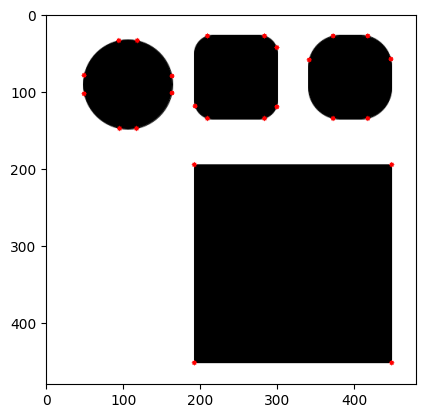

In [40]:
do_shi_tomasi()

That might be because the number of corners it's looking for is 25. Let's see what happens if I reduce `maxCorners` to `5`:

<ipython-input-36-3e5e8907d92c>:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


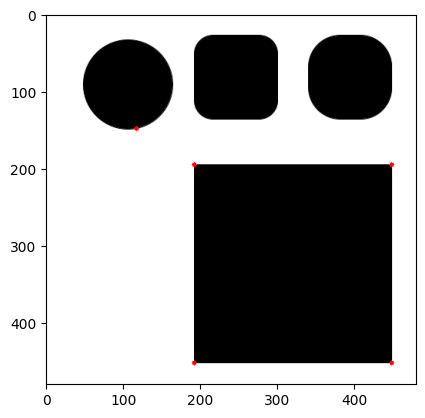

In [43]:
do_shi_tomasi(maxCorners=5)

Interestingly, reducing `maxCorners` doesn't avoid corner detection on the circle. I'll increase the `qualityLevel` and see if that avoids detection of corners on the circle:

<ipython-input-36-3e5e8907d92c>:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


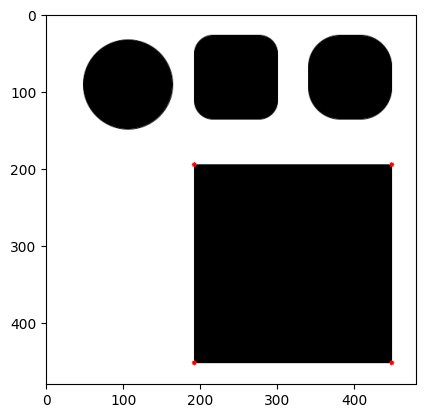

In [57]:
do_shi_tomasi(maxCorners=100, qualityLevel=0.04)

After quadrupuling the `qualityLevel`, even if `maxCorners` is `100`, the corners on the rounded squares are not detected. Let's see how changing `minDistance` (from `10` to `100`) affects corner detection:

<ipython-input-36-3e5e8907d92c>:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


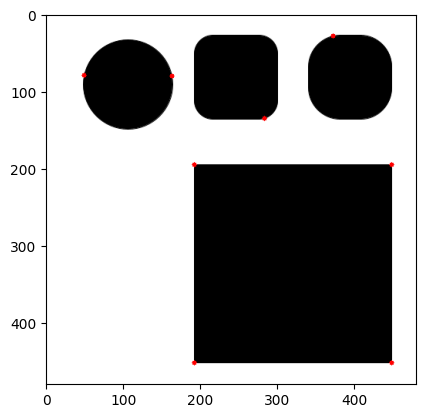

In [69]:
do_shi_tomasi(minDistance=100)

Fewer corners are detected because of the larger minimum distance required, but the quality of corners detected doesn't improve.

## Blob Detectors

I'll be running the same code as the [scikit-image documentation](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html) with different images, going from slowest and most accurate (Laplacian of Gaussian) to fastest (Determinant of Hessian).

### Laplacian of Gaussian

In [2]:
def do_blob_log(fname='/content/shapes1.png', max_sigma=30, num_sigma=10, threshold=0.1):
  image = cv.imread(fname)
  image_gray = rgb2gray(image)

  blobs_log = blob_log(image_gray, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)

  # Compute radii in the 3rd column.
  blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
  fig, ax = plt.subplots(1, 1, figsize=(3, 3))

  ax.set_title(f'Laplacian of Gaussian: {len(blobs_log)} blobs')
  ax.imshow(image)

  for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

  ax.set_axis_off()

  plt.tight_layout()
  plt.show()

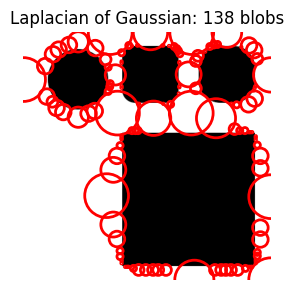

In [58]:
do_blob_log()

That took about 10 seconds to run and did not result in what I was expecting---it seems to be identifying the white space as blobs? I'm not sure how to interpret this result. I'll change the `max_sigma` value and see what that does.

A very small `max_sigma` results in many smaller blobs around the edges of the shapes. A large `max_sigma` results in fewer, much larger blobs. 

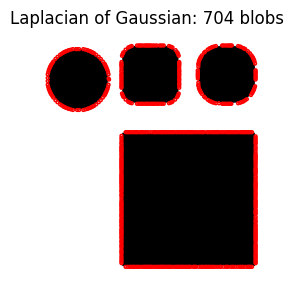

In [59]:
do_blob_log(max_sigma=1)

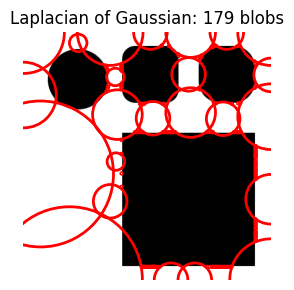

In [60]:
do_blob_log(max_sigma=100)

Changing `num_sigma` next (from `10` to `1` and `100`):

A smaller `num_sigma` has a similar effect to a small `max_sigma` (many small blobs). 

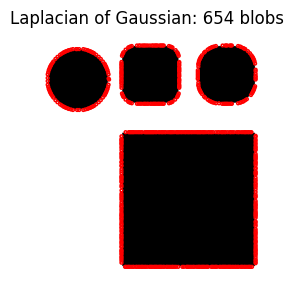

In [61]:
do_blob_log(num_sigma=1)

A larger `num_sigma` results in fewer blobs but of greatly varying sizes.

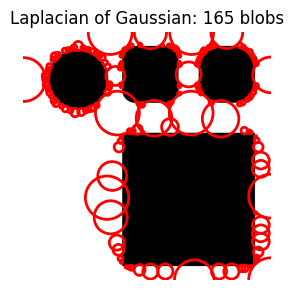

In [62]:
do_blob_log(num_sigma=100)

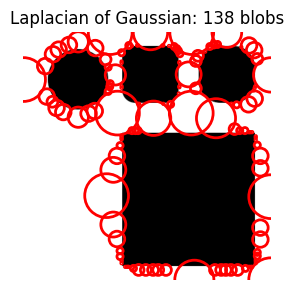

In [63]:
do_blob_log(threshold=0.01)

As `threshold` gets larger, the number of blobs decreases significantly.

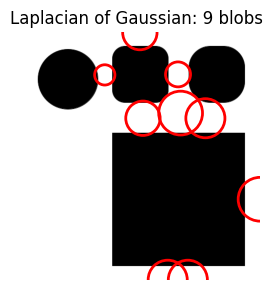

In [64]:
do_blob_log(threshold=0.4)

### Difference of Gaussian

In [65]:
def do_blob_dog(fname='/content/shapes1.png', max_sigma=30, threshold=0.1):
  image = cv.imread(fname)
  image_gray = rgb2gray(image)

  blobs_dog = blob_dog(image_gray, max_sigma=max_sigma, threshold=threshold)
  blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

  fig, ax = plt.subplots(1, 1, figsize=(3, 3))

  ax.set_title(f'Difference of Gaussian: {len(blobs_dog)} blobs')
  ax.imshow(image)

  for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

  ax.set_axis_off()

  plt.tight_layout()
  plt.show()

I still don't understand why it's focused on detecting the white space and not the black objects. 

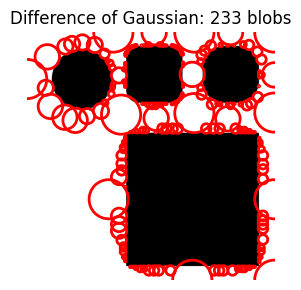

In [66]:
do_blob_dog()

I wonder if I reverse the colors in the image (manually, in Google Slides) would that change the results?

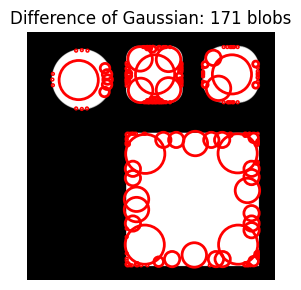

In [67]:
do_blob_dog(fname='/content/shapes3.png')

Yup---it's now focused on the bright (white) objects compared to the dark (black) background. It's still doing a terrible job at detecting the shapes as it has way too many blobs.

A larger `max_sigma` (`100` instead of `30`) doesn't improve the results (we get only marginally closer to 4 total blobs).

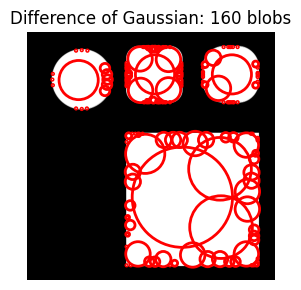

In [68]:
do_blob_dog(fname='/content/shapes3.png', max_sigma=100)

A larger `threshold` value (`0.32` instead of `0.1`) captures one blog per small shape but doesn't detect the largest square as a single blob (instead, it captures each corner as its own blob).

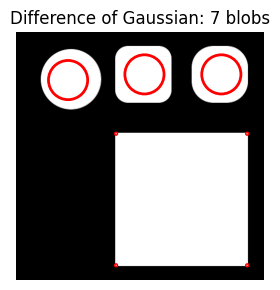

In [73]:
do_blob_dog(fname='/content/shapes3.png', threshold=0.32)

Increasing `max_sigma` with a larger `threshold` gets the desired result---all four shapes are detected with one blob each. 

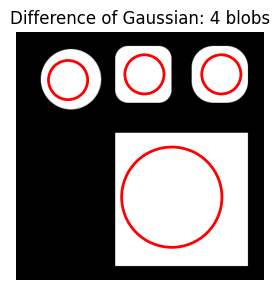

In [74]:
do_blob_dog(fname='/content/shapes3.png', max_sigma=100, threshold=0.35)

I'll retry Laplacian of Gaussian on this new image with white shapes on a black background.

Laplacian of Gaussian requires a slightly larger `threshold` of `0.45` to get the same results. Increasing `max_sigma` (with `num_sigma` at `10` or `3` and `threshold=0.35`) picks up additional noise (four corners of the square).

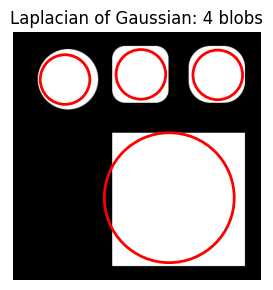

In [75]:
do_blob_log(fname='/content/shapes3.png', max_sigma=100, threshold=0.45)

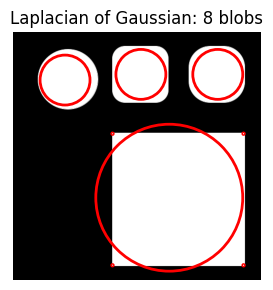

In [76]:
do_blob_log(fname='/content/shapes3.png', max_sigma=300, threshold=0.35)

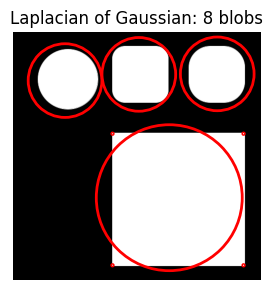

In [77]:
do_blob_log(fname='/content/shapes3.png', max_sigma=100, num_sigma=3, threshold=0.35)

### Determinant of Hessian

In [82]:
def do_blob_doh(fname='/content/shapes3.png', max_sigma=30, threshold=0.01):
  image = cv.imread(fname)
  image_gray = rgb2gray(image)

  blobs_doh = blob_doh(image_gray, max_sigma=max_sigma, threshold=threshold)

  fig, ax = plt.subplots(1, 1, figsize=(3, 3))

  ax.set_title(f'Determinant of Hessian: {len(blobs_doh)} blobs')
  ax.imshow(image)

  for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

  ax.set_axis_off()

  plt.tight_layout()
  plt.show()

The documentation values of `max_sigma=30` and `threshold=0.01` result in 21 blobs for the Determinant of Hessian approach.

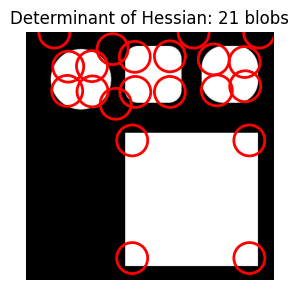

In [83]:
do_blob_doh()

Increasing `max_sigma` significantly gets the correct number of blobs (4) but they are erratically positioned and don't match the target shapes.

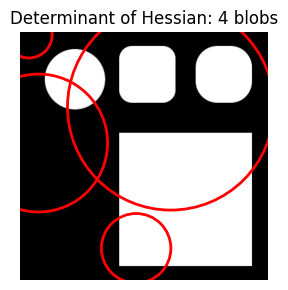

In [86]:
do_blob_doh(max_sigma=200)

I can't quite find the right combination of parameters with the Determimant of Hessian approach. The best I can do (with the limited manual combinations I tried) is to get the right number of blobs (4) with the wrong placement.

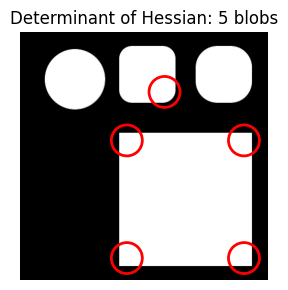

In [98]:
do_blob_doh(threshold=0.023)

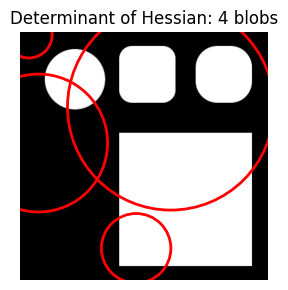

In [126]:
do_blob_doh(max_sigma=200, threshold=0.01)

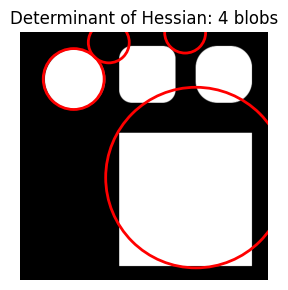

In [152]:
do_blob_doh(max_sigma=175, threshold=0.025)

## Scale-Invariant Feature Transform (SIFT)

From the [OpenCV docs](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html):

> A corner may not be a corner if the image is scaled.

In the image below, I created a small rounded square at the top left. I copied that square and scaled it up a few times to get the "zoomed-in" corner on the bottom right. 

When using the Harris Corner detection algorithm with an increased `blockSize` the rounded corners in the small version and large version of the square are detected, however I'm not sure if such large blocks are recommended or ever used. There also seems to be some overlap between the bottom right corner of the small square and the top right corner of the large square.

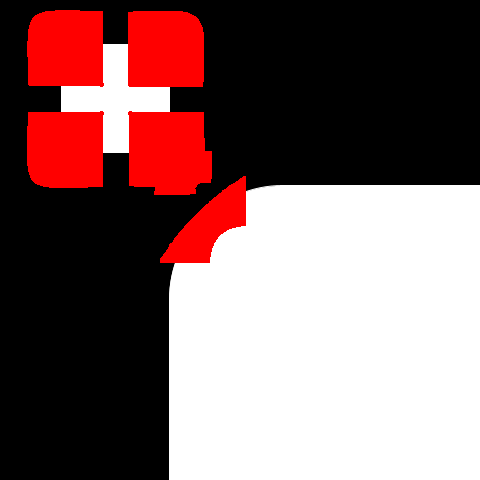

In [22]:
do_corner_harris(fname='/content/shapes4.png', blockSize=80)

If I use SIFT with a larger `edgeThreshold` than the default, it seems to identify key points along the rounded corner of the large square, and the entire smaller square. I'm not entirely sure how to interpret these keypoints so I can't say if it's better or worse than the Harris Corner Detector.

In [1]:
def do_sift(fname='/content/shapes4.png', edgeThreshold=10):
  img = cv.imread(fname)
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

  sift = cv.SIFT_create(edgeThreshold=edgeThreshold)
  kp = sift.detect(gray, mask=None)

  img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  cv2_imshow(img)

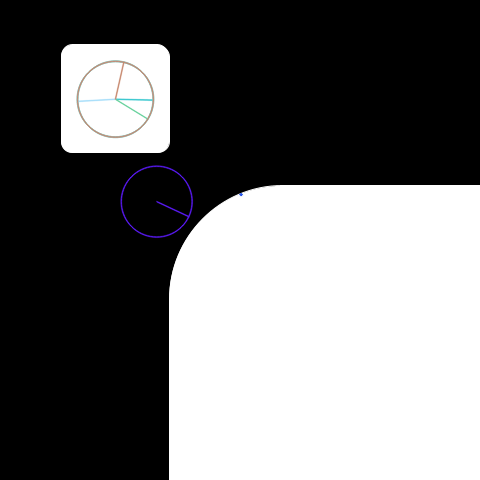

In [33]:
do_sift()

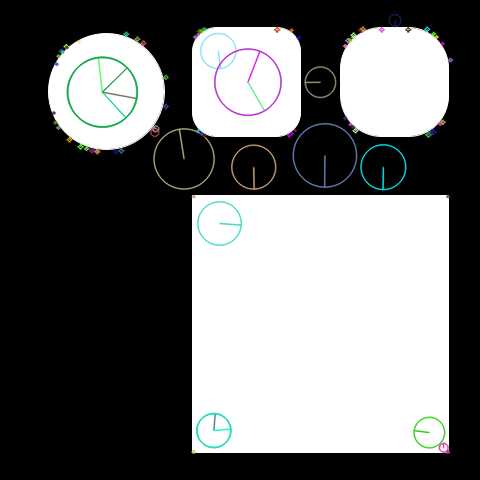

In [35]:
do_sift(fname='/content/shapes3.png', edgeThreshold=50)

With a larger `edgeThreshold` than the default, SIFT is placing key points on all corners of the shapes in the image, including points on the circle.

## Histogram of Oriented Gradients (HoG)

In [10]:
def do_hog(fname='/content/shapes3.png'):
  image = cv.imread(fname)

  fd, hog_image = hog(
      image,
      orientations=8,
      pixels_per_cell=(16, 16),
      cells_per_block=(1, 1),
      visualize=True,
      channel_axis=-1,
  )

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  ax1.set_title('Input image')

  # Rescale histogram for better display
  hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

  ax2.axis('off')
  ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
  ax2.set_title('Histogram of Oriented Gradients')
  plt.show()

The Histogram of Gradients algorithm generally seems to find the gradient at each point of the shape's boundary. 

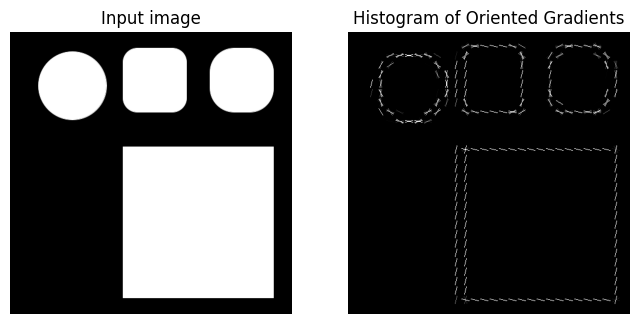

In [11]:
do_hog()

I'll give it a much simpler image (straight lines) to see how it transforms that:

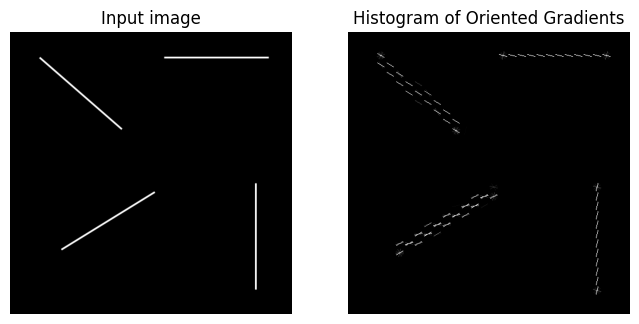

In [12]:
do_hog(fname='/content/shapes5.png')

It's interesting to note that on the diagonal lines it has "thicker" gradients than the vertical and horizontal lines.

## Final Thoughts

Computer Vision is obviously a vast field with a significant history of research and applications. I'm not very familiar with this field outside of what I've learned and applied from the fastai course and Kaggle competitions about image recognition, so this was a helpful exercise to slightly expand my understanding of the CV universe.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).